In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import fetch_data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [9]:
# all_sits_df, pp_df = fetch_data()
all_sits_df = pd.read_csv('all_sits_player_goal_data.csv')
pp_df = pd.read_csv('pp_player_goal_data.csv')


In [10]:
def group_data(df):
    df.season = df.season.astype(int)
    df['prev_season'] = df['season'] - 10001
    groupby_columns = ['player', 'api_id', 'season', 'player_upper', 
                       'birthday', 'position', 'shoots',
                       'prev_season', 'position_type', 
                       'season_age']
    agg_columns = ['g', 'a1', 'a2', 'points', 'toi', 'gp', 'isf', 'iff', 'icf']
    df = df.groupby(groupby_columns)[agg_columns].sum().reset_index()
    return df

all_sits_df = group_data(all_sits_df)
pp_df = group_data(pp_df)

In [11]:
#join the pp stats to the regular stats

total_df = all_sits_df.merge(pp_df[['api_id', 'g', 'a1', 'a2', 'season',
                                    'points', 'toi', 'gp', 'isf', 'iff', 'icf']], on=['api_id', 'season'],
                             suffixes=[None, '_pp'])

#create dataframe of season to season goal correlation
next_df = total_df.merge(total_df[['api_id', 'season', 'prev_season', 'g', 'season_age']], 
                         how='inner',
                         left_on=['api_id', 'season'], 
                         right_on=['api_id', 'prev_season'],
                         suffixes=[None, '_next'])

# Correlations

Let's look at the correlations between the existing features and our target variables to spot collinearity or features that don't correlate to extract them as inputs to the model. This can be done faster using some sort of regularized regression but to start we'll keep things a little manual and straight forward while relying on our domain knowledge to build the best model we can.

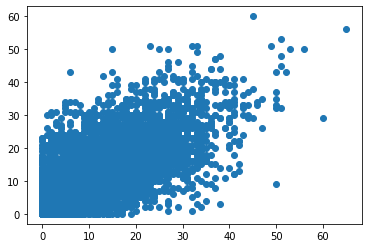

In [12]:
#total scatter correlation
#this is the test of linearity
plt.scatter(next_df[['g']], next_df[['g_next']])

In [13]:
#Now start building a new linear model that takes into affect new features and maybe use 
#ridge or lasso for feature selection. Also doing a bagging regressor with this too
#TODO: need to do some better feature/parameter creation i bet
#features:
#2. player age done
#4. position (dummy variable) done
#5. toi_gp done
#6. previous years goals done
#7. previous years a1 done
#8. previous years a2 done
#9. previous years points done
#10. Past average of past two years goals
#11. pp_toi done
#12. shooting percentage done
#13. shooting percentage difference from carreer shooting percentage over span of data done
#14. career goals per season average over span of data done

#position dummy variable
next_df = pd.concat([next_df, pd.get_dummies(next_df['position_type'], prefix='pos')], axis=1)
#toi_gp
next_df['toi_gp'] = round(next_df['toi']/next_df['gp'], 2)
next_df['sh_percent'] = round(next_df['g']/next_df['isf'], 3)
next_df['sh_percent_pp'] = round(next_df['g_pp']/next_df['isf_pp'], 3)

#avg goals over career
#TODO redo this number of season counts
next_df = next_df.sort_values(['api_id', 'season'])
next_df["number_season"] = next_df.groupby("api_id")["season"].rank(method="first", ascending=True)

next_df['goals_shift'] = next_df['g'] + next_df['g'].shift(1)
next_df['cum_goals'] = np.where(next_df['api_id'] == next_df['api_id'].shift(1), 
                                    next_df['goals_shift'], 
                                    next_df['g'])
next_df['avg_goals_season'] = next_df['cum_goals']/next_df['number_season']

#avg shooting percentage over career
next_df['cum_shots'] = np.where(next_df['api_id'] == next_df['api_id'].shift(1), 
                                    next_df['isf'] + next_df['isf'].shift(1), 
                                    next_df['isf'])
next_df['avg_sh_perc'] = round(next_df['cum_goals']/next_df['cum_shots'], 3)

#diff of season sh% from career avg
next_df['sh_perc_diff'] = next_df['sh_percent'] - next_df['avg_sh_perc']

#TODO get last two seasons avg
next_df['next_prev_season'] = next_df['prev_season'] - 10001
next_df = next_df.merge(next_df[['api_id', 'season', 'g']], 
                        left_on=['api_id', 'prev_season'], 
                        right_on=['api_id','season'], how='left')
next_df = next_df.merge(next_df[['api_id', 'season_x', 'g_x']], 
                        left_on=['api_id', 'next_prev_season'], 
                        right_on=['api_id','season_x'], how='left',
                        suffixes=[None, '_z'])
next_df['g_avg_past_2_seasons'] = (next_df['g_y'] + next_df['g_x_z'])/2

#prorate goals for strike shortened season

next_df['g_x'] = np.where(next_df['season_x'] == 20122013, (next_df['g_x']/next_df['gp']) * 82, next_df['g_x'])
next_df['g_pp'] = np.where(next_df['season_x'] == 20122013, (next_df['g_pp']/next_df['gp']) * 82, next_df['g_pp'])
#dropping the columns i don't need and renaming some to be more useful
columns = ['player', 'api_id', 'season_x', 'player_upper', 'position', 'shoots', 'season_age_next',
           'g_x', 'a1', 'a2', 'points', 'toi', 'gp', 'isf', 'iff', 'icf', 'g_pp', 'a1_pp', 'a2_pp',
           'points_pp', 'toi_pp', 'gp_pp', 'isf_pp', 'iff_pp', 'season_next', 'g_next', 'pos_D',
           'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 'avg_sh_perc', 
           'sh_perc_diff', 'g_avg_past_2_seasons']

renamed_columns = ['player', 'api_id', 'season', 'player_upper', 'position', 'shoots', 'next_season_age',
                   'g', 'a1', 'a2', 'points', 'toi', 'gp', 'isf', 'iff', 'icf', 'g_pp', 'a1_pp', 'a2_pp',
                   'points_pp', 'toi_pp', 'gp_pp', 'isf_pp', 'iff_pp', 'season_next', 'g_next', 'pos_D',
                   'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 
                   'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons']
next_df = next_df[columns]
next_df.columns = renamed_columns

In [15]:
next_df = next_df.replace(np.nan, 0)
feature_columns = ['next_season_age',
                   'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp', 'a1_pp', 'a2_pp',
                   'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D',
                   'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp', 'avg_goals_season', 
                   'avg_sh_perc', 'sh_perc_diff', 'g_avg_past_2_seasons'] 

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    next_df[feature_columns], next_df[['g_next']], test_size=0.2, random_state=42)

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

KBest = SelectKBest(score_func = f_classif, k = 'all')
KBest = KBest.fit(x_train, y_train)

/Users/matthewbarlowe/.virtualenvs/nhl/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [17]:
df_scores = pd.DataFrame({'features': x_train.columns, 'f_classif score': KBest.scores_, 'pValue': KBest.pvalues_ })
df_scores

,features,f_classif score,pValue
0,next_season_age,1.513017,1.078667e-02
1,g,180.735202,0.000000e+00
2,a1,93.351849,0.000000e+00
3,a2,48.986407,0.000000e+00
4,toi,41.328268,0.000000e+00
5,gp,42.947215,0.000000e+00
6,isf,128.326199,0.000000e+00
7,iff,123.250032,0.000000e+00
8,g_pp,98.189141,0.000000e+00
9,a1_pp,44.733404,0.000000e+00


In [18]:
cols = KBest.get_support(indices=True)
features = x_train.columns[cols]
features

Index(['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp',
       'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D',
       'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp',
       'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff',
       'g_avg_past_2_seasons'],
      dtype='object')

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
import math
from functools import reduce
import itertools
import time

def cv_model(x, y, model, results: dict, n_estimators: int, n_splits: int):
    r_squared = []
    mse_list = []
    rmse_list = []
    mae_list = []
    kf = KFold(n_splits=n_splits)
    estimator = BaggingRegressor(model, n_estimators=n_estimators, bootstrap=True)
    for train_index, test_index in kf.split(x):

        train_x = x[list(features)].iloc[train_index]
        train_y = y.iloc[train_index]
        test_x = x[list(features)].iloc[test_index]
        test_y = y.iloc[test_index]
        '''
        if x == 0:
            print(f"Fitting Model... {x+1}", end=",")
        elif x == 9:
            print(f"{x+1}")
        else:
            print(f"{x+1}", end=",")
        x = x + 1
        '''
        estimator.fit(train_x, train_y.values[:,0])
        y_hat_values = estimator.predict(test_x)
        #Testing the coefficient of determination in the training set. R^2 is the proportion
    #of the variance in the dependent variable that is predictable from the independent variables
        r_squared.append(estimator.score(test_x, test_y))
    #Mean Squared Error is used to compare between different models where the smaller the number the better
    #An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
    #estimator or MVUE(minimum Variance Unbiased Estimator)
        mse_list.append(mean_squared_error(test_y, y_hat_values))
        rmse_list.append(math.sqrt(mean_squared_error(test_y, y_hat_values)))
        mae_list.append(mean_absolute_error(test_y, y_hat_values))
    avg_r_squared = round(reduce(lambda x, y: x + y, r_squared) / len(r_squared), 4)
    avg_mse = round(reduce(lambda x, y: x + y, mse_list) / len(mse_list), 4)
    avg_rmse = round(reduce(lambda x, y: x + y, rmse_list) / len(rmse_list), 4)
    avg_mae = round(reduce(lambda x, y: x + y, mae_list) / len(mae_list), 4)
    print(f"Building model with features: {features}")
    print(("Baseline linear model test set metrics:\n"
           f"Average R^2 for test set: {avg_r_squared}\n"
           f"Average Mean Squared Error for test set: {avg_mse}\n"
           f"Average Root Mean Squared Error for test set: {avg_rmse}\n"
           f"Average Mean Absolute Error for test set: {avg_mae}"
           ))
    
    return estimator

In [27]:
model_dict = {'model': '', 'features': '', 'r_squared': '', 'mse': '', 'rmse': ''}
estimator = cv_model(x_train, y_train, LinearRegression(), model_dict, 500, 10)

Building model with features: Index(['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp',
       'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D',
       'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp',
       'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff',
       'g_avg_past_2_seasons'],
      dtype='object')
Baseline linear model test set metrics:
Average R^2 for test set: 0.6357
Average Mean Squared Error for test set: 29.5312
Average Root Mean Squared Error for test set: 5.4304
Average Mean Absolute Error for test set: 3.9075


In [28]:
estimator.score(x_test[list(features)], y_test)

0.6110646185637705

In [29]:
from sklearn.linear_model import Ridge
ridge_estimator = cv_model(x_train, y_train, Ridge(alpha=1), model_dict, 500, 10)

Building model with features: Index(['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp',
       'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D',
       'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp',
       'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff',
       'g_avg_past_2_seasons'],
      dtype='object')
Baseline linear model test set metrics:
Average R^2 for test set: 0.6358
Average Mean Squared Error for test set: 29.5278
Average Root Mean Squared Error for test set: 5.4301
Average Mean Absolute Error for test set: 3.9071


In [30]:
ridge_estimator.score(x_test[list(features)], y_test)

0.6114184888425922

In [31]:
from sklearn.linear_model import Lasso
lasso_estimator = cv_model(x_train, y_train, Lasso(alpha=1), model_dict, 500, 10)

Building model with features: Index(['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp',
       'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D',
       'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp',
       'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff',
       'g_avg_past_2_seasons'],
      dtype='object')
Baseline linear model test set metrics:
Average R^2 for test set: 0.6193
Average Mean Squared Error for test set: 30.8675
Average Root Mean Squared Error for test set: 5.5508
Average Mean Absolute Error for test set: 3.9946


In [32]:
lasso_estimator.score(x_test[list(features)], y_test)

0.5927150051041936

In [33]:
from sklearn.linear_model import ElasticNet
elastic_estimator = cv_model(x_train, y_train, ElasticNet(alpha=1), model_dict, 500, 10)

Building model with features: Index(['next_season_age', 'g', 'a1', 'a2', 'toi', 'gp', 'isf', 'iff', 'g_pp',
       'a1_pp', 'a2_pp', 'toi_pp', 'isf_pp', 'iff_pp', 'season_next', 'pos_D',
       'pos_D/F', 'pos_F', 'toi_gp', 'sh_percent', 'sh_percent_pp',
       'avg_goals_season', 'avg_sh_perc', 'sh_perc_diff',
       'g_avg_past_2_seasons'],
      dtype='object')
Baseline linear model test set metrics:
Average R^2 for test set: 0.6221
Average Mean Squared Error for test set: 30.6416
Average Root Mean Squared Error for test set: 5.5305
Average Mean Absolute Error for test set: 3.9774


In [34]:
elastic_estimator.score(x_test[list(features)], y_test)

0.5948137900476265

In [23]:
#graphing results of distribution
test_row = x_test.loc[2036, list(features)]
results = []
for m in estimator.estimators_:
    results.append(m.predict([test_row]))
results = [x[0] for x in results]

plt.hist(results, bins=20)

In [ ]:
def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    Get a prediction interval for a linear regression.
    
    INPUTS: 
        - Single prediction, 
        - y_test
        - All test set predictions,
        - Prediction interval threshold (default = .95) 
    OUTPUT: 
        - Prediction interval for single prediction
    '''
    
    #get standard deviation of y_test
    sum_errs = np.sum((y_test - test_predictions)**2)
    stdev = np.sqrt(1 / (len(y_test) - 2) * sum_errs)#get interval from standard deviation
    one_minus_pi = 1 - pi
    ppf_lookup = 1 - (one_minus_pi / 2)
    z_score = stats.norm.ppf(ppf_lookup)
    interval = z_score * stdev#generate prediction interval lower and upper bound
    lower, upper = prediction - interval, prediction + interval    return lower, prediction, upper

In [85]:
#pearson correlation coefficients
forward_corr = forwards_df['g_x'].corr(forwards_df['g_y'])
def_corr = defense_df['g_x'].corr(defense_df['g_y'])
total_corr = new_df['g_x'].corr(new_df['g_y'])
print((f"Foward pearson R: {round(forward_corr, 2)}\n"
       f"Defense pearson R: {round(def_corr, 2)}\n"
       f"All Position Pearson R: {round(total_corr, 2)}"))

Foward pearson R: 0.65
Defense pearson R: 0.63
All Position Pearson R: 0.74


In [86]:
#create a baseline linear model using previous season goals to predict next season
#goals

from sklearn.model_selection import train_test_split

#create test and train dataframes
train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=8675309)



(array([406., 532., 438., 405., 537., 310., 281., 217., 212., 114.,  72.,
         37.,  43.,  14.,   4.,  11.,   2.,   1.,   1.,   1.]),
 array([ 0.  ,  3.25,  6.5 ,  9.75, 13.  , 16.25, 19.5 , 22.75, 26.  ,
        29.25, 32.5 , 35.75, 39.  , 42.25, 45.5 , 48.75, 52.  , 55.25,
        58.5 , 61.75, 65.  ]),
 <BarContainer object of 20 artists>)

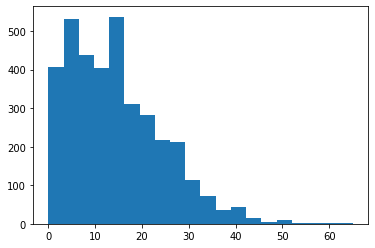

In [87]:
#Distribution of the data fits a poisson or pareto distribution
#this may be useful for more advanced models
plt.hist(new_df.g_x, bins=20)

In [ ]:
#need write functions to create models and run them through the metrics createthe outputs

def create_model():
    pass

def model_metrics():
    pass

In [88]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score

n_estimators = 5000
reg = BaggingRegressor(LinearRegression(), n_estimators=n_estimators, bootstrap=True)

reg.fit(train_df[['g_x']], train_df[['g_y']].values[:,0])

BaggingRegressor(base_estimator=LinearRegression(), n_estimators=5000)

In [89]:
#This is bootstrapping a confidence interval for the results of linear regresssions
def bootstrap_prediction(bag_reg: BaggingRegressor, value: int):
    results = []
    for m in bag_reg.estimators_:
        results.append(m.predict(np.array([[value]]))[0])
    return results

In [91]:
import math
pd.options.mode.chained_assignment = None 
train_df[['y_hat']] = reg.predict(train_df[['g_x']])
#Testing the coefficient of determination in the training set. R^2 is the proportion
#of the variance in the dependent variable that is predictable from the independent variables
r_squared = reg.score(train_df[['g_y']], train_df[['y_hat']])
#Mean Squared Error is used to compare between different models where the smaller the number the better
#An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
#estimator or MVUE(minimum Variance Unbiased Estimator)
mse = mean_squared_error(train_df[['g_y']], train_df[['y_hat']])
print(("Baseline linear model train set metrics:\n"
       f"R^2 for train set: {round(r_squared, 4)}\n"
       f"Mean Squared Error for train set: {round(mse, 4)}\n"
       f"Root Mean Squared Error for train set: {round(math.sqrt(mse), 2)}"))

Baseline linear model train set metrics:
R^2 for train set: 0.4469
Mean Squared Error for train set: 40.8864
Root Mean Squared Error for train set: 6.39


In [92]:
test_df[['y_hat']] = reg.predict(test_df[['g_x']])
#Testing the coefficient of determination in the testing set. R^2 is the proportion
#of the variance in the dependent variable that is predictable from the independent variables
r_squared = reg.score(test_df[['g_y']], test_df[['y_hat']])
#Mean Squared Error is used to compare between different models where the smaller the number the better
#An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
#estimator or MVUE(minimum Variance Unbiased Estimator)
mse = mean_squared_error(test_df[['g_y']], test_df[['y_hat']])
print(("Baseline linear model test set metrics:\n"
       f"R^2 for test set: {round(r_squared, 4)}\n"
       f"Mean Squared Error for test set: {round(mse, 4)}\n"
       f"Root Mean Squared Error for test set: {round(math.sqrt(mse), 2)}"))

Baseline linear model test set metrics:
R^2 for test set: 0.4171
Mean Squared Error for test set: 45.5186
Root Mean Squared Error for test set: 6.75


In [93]:
train_df.columns

Index(['player_x', 'api_id', 'g_x', 'season_x', 'a1', 'a2', 'points', 'toi',
       'gp', 'season_minus_one_x', 'position_type_x', 'season_age_x',
       'player_y', 'g_y', 'season_y', 'season_minus_one_y', 'position_type_y',
       'season_age_y', 'season_20082009', 'season_20092010', 'season_20102011',
       'season_20112012', 'season_20122013', 'season_20142015',
       'season_20152016', 'season_20162017', 'season_20172018',
       'season_20182019', 'season_20192020', 'pos_D', 'pos_D/F', 'pos_F',
       'toi_gp', 'y_hat'],
      dtype='object')

In [94]:
#Start training the model using more variables and compare to the baseline
n_estimators = 5000
multi_var_reg = BaggingRegressor(LinearRegression(), n_estimators=n_estimators, bootstrap=True)

multi_var_reg.fit(train_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 
                            'points', 'season_y', 'pos_D', 'pos_D/F', 'pos_F']], train_df[['g_y']].values[:,0])


BaggingRegressor(base_estimator=LinearRegression(), n_estimators=5000)

In [95]:
import math
pd.options.mode.chained_assignment = None 
train_df[['y_hat_multi']] = multi_var_reg.predict(train_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 
                                                            'points', 'season_y', 'pos_D', 'pos_D/F', 'pos_F']])


In [96]:
#Testing the coefficient of determination in the training set. R^2 is the proportion
#of the variance in the dependent variable that is predictable from the independent variables
r_squared = multi_var_reg.score(train_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 
                                          'points', 'season_y', 'pos_D', 'pos_D/F', 'pos_F']], train_df[['g_y']])
#Mean Squared Error is used to compare between different models where the smaller the number the better
#An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
#estimator or MVUE(minimum Variance Unbiased Estimator)
mse = mean_squared_error(train_df[['g_y']], train_df[['y_hat_multi']])
print(("Baseline linear model train set metrics:\n"
       f"R^2 for train set: {round(r_squared, 4)}\n"
       f"Mean Squared Error for train set: {round(mse, 4)}\n"
       f"Root Mean Squared Error for train set: {round(math.sqrt(mse), 2)}"))

Baseline linear model train set metrics:
R^2 for train set: 0.5916
Mean Squared Error for train set: 37.2311
Root Mean Squared Error for train set: 6.1


In [97]:
from sklearn.metrics import mean_absolute_error
test_df[['y_hat_multi']] = multi_var_reg.predict(test_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 
                                                            'points', 'season_y', 'pos_D', 'pos_D/F', 'pos_F']])

#Testing the coefficient of determination in the training set. R^2 is the proportion
#of the variance in the dependent variable that is predictable from the independent variables
r_squared = multi_var_reg.score(test_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 
                                          'points', 'season_y', 'pos_D', 'pos_D/F', 'pos_F']], test_df[['g_y']])
#Mean Squared Error is used to compare between different models where the smaller the number the better
#An unbiased esitmator with the smallest variance among all unbiased estimators is the best unbiased
#estimator or MVUE(minimum Variance Unbiased Estimator)
mse = mean_squared_error(test_df[['g_y']], test_df[['y_hat_multi']])
print(("Baseline linear model test set metrics:\n"
       f"R^2 for test set: {round(r_squared, 4)}\n"
       f"Mean Squared Error for test set: {round(mse, 4)}\n"
       f"Root Mean Squared Error for test set: {round(math.sqrt(mse), 2)}\n"
       f"Mean Absolute Error for test set: "
       f"{round(mean_absolute_error(test_df[['g_y']], test_df[['y_hat_multi']]), 2)}"))

#This model does allright however i think it underates the ability of a player to score more goals the next season
#especially on outliers when those are usually the more talented players who would have a higher probability 
#of scoring at or more. I think there should be some probability in my distributions of prediction intervals
#to score more goals however slight Not sure how to get there yet. 2020-10-18

Baseline linear model test set metrics:
R^2 for test set: 0.579
Mean Squared Error for test set: 42.3895
Root Mean Squared Error for test set: 6.51
Mean Absolute Error for test set: 4.86


In [72]:
test_row = test_df[['g_x','season_age_y', 'toi_gp', 'a1', 'a2', 'points', 
                    'season_y', 'pos_D', 'pos_D/F', 'pos_F']].loc[5359, :]

np.array([test_row])

array([[30., 13., 59.]])

In [73]:
results = []
for m in multi_var_reg.estimators_:
    results.append(m.predict([test_row]))

In [74]:
multi_var_reg.predict([test_row])

array([22.31486903])

In [75]:
results = [x[0] for x in results]

In [76]:
test_row

g_x       30.0
a2        13.0
points    59.0
Name: 5359, dtype: float64

(array([  1.,   4.,   4.,   9.,  27.,  68., 137., 272., 447., 659., 727.,
        756., 659., 501., 378., 193., 106.,  35.,  15.,   2.]),
 array([20.90087746, 21.02705963, 21.1532418 , 21.27942397, 21.40560614,
        21.5317883 , 21.65797047, 21.78415264, 21.91033481, 22.03651697,
        22.16269914, 22.28888131, 22.41506348, 22.54124564, 22.66742781,
        22.79360998, 22.91979215, 23.04597431, 23.17215648, 23.29833865,
        23.42452082]),
 <BarContainer object of 20 artists>)

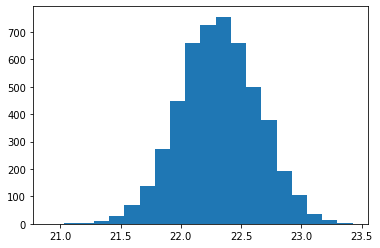

In [77]:
plt.hist(results, bins=20)


In [54]:
forty_df = new_df[new_df.g_x >= 30]

In [55]:
len(forty_df[forty_df.g_y >= 30].player_x.unique())/len(forty_df.player_x.unique())

0.38095238095238093

In [47]:
len(forty_df[forty_df.g_y >= 30].player_x.unique())

56

(array([ 1.,  4.,  1.,  1.,  3.,  6.,  3.,  8.,  4., 14.,  7.,  4.,  2.,
         2.,  1.,  1.,  3.,  1.,  1.,  1.]),
 array([ 9.  , 11.55, 14.1 , 16.65, 19.2 , 21.75, 24.3 , 26.85, 29.4 ,
        31.95, 34.5 , 37.05, 39.6 , 42.15, 44.7 , 47.25, 49.8 , 52.35,
        54.9 , 57.45, 60.  ]),
 <BarContainer object of 20 artists>)

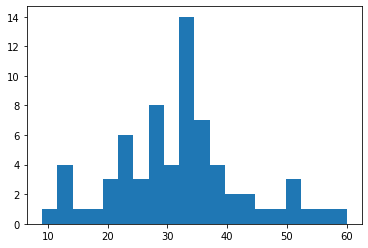

In [35]:
plt.hist(forty_df['g_y'], bins=20)

In [ ]:
#write a funciton to determine the pareto division of how much of the fat tail is held by what 
#percentage of players

In [216]:
#pareto distribution function
import math
alpha = 1/(1-(math.log10(.7)/math.log10(0.3)))
x_sub_m = 1
def pareto_prob(x):
    """
    returns probability that some number X will be greater than x by the distribution of the Pareto curve
    defined by observed goal scoring behavior
    """
    alpha = 1/(1-(math.log10(.7)/math.log10(0.3)))
    x_sub_m = 1
    return (x_sub_m/x)^alpha

In [65]:
total_seasons=new_df.shape[0]

In [66]:
more_goals_df = new_df[new_df.g_y > new_df.g_x]

In [67]:
seasons_w_more_goals = more_goals_df.shape

In [69]:
seasons_w_more_goals


(3571, 34)

In [70]:
seasons_w_more_goals[0]/total_seasons

0.41202261451482636

In [72]:
new_df.season_x.min()

20072008

In [73]:
f_more_goals = forwards_df[forwards_df.g_y > forwards_df.g_x].shape[0]
total_f_seasons = forwards_df.shape[0]
f_more_goals/total_f_seasons

0.42791842475386777